In [1]:
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets import load_iris
import statsmodels.stats.api as sms
from arch.bootstrap import IndependentSamplesBootstrap

In [2]:
# параметр для задания толщины линии# парам 
plt.rcParams['lines.linewidth'] = 1
# параметр для задания ширины точек
plt.rcParams['lines.markersize'] = 6
# параметр для задания шрифта осей x и y (цифр на осях)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
# параметр для задания шрифта на осях
plt.rcParams['legend.fontsize'] = 24
# параметр для задания шрифта заголовка
plt.rcParams['axes.titlesize'] = 36
# параметр для задания шрифта осей x и y (название оси)
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = (8.0, 4.0)
# параметр для задания шрифта вспомагательных записей на графику (annotate или text)
plt.rcParams['font.size'] = 10

In [3]:
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Построим boxplot-ы

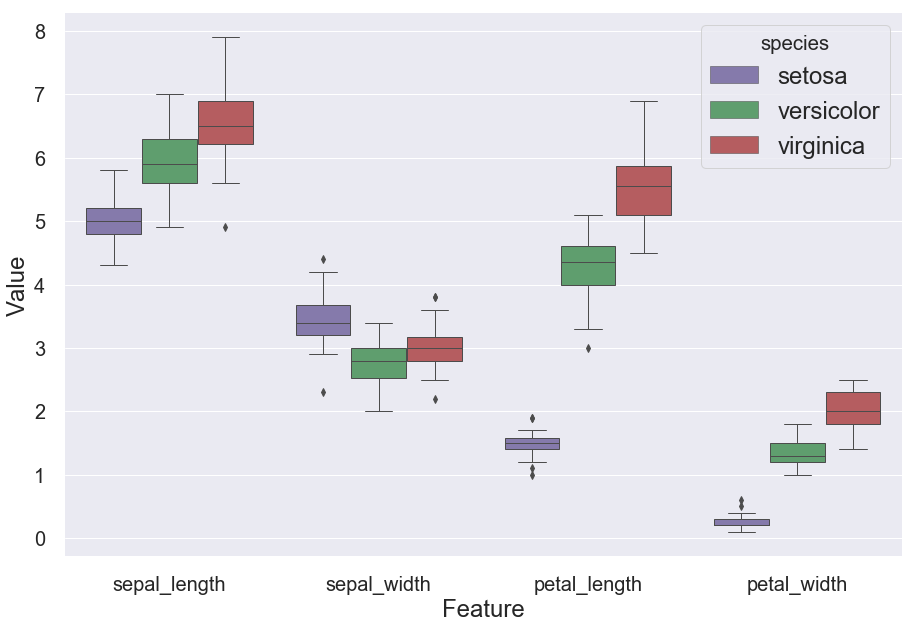

In [4]:
plt.figure(figsize=(15, 10))
df_melt = df.melt(id_vars=["species"], 
                  value_vars=df.columns[:-1], 
                  var_name="Feature",
                  value_name="Value")  
sns.boxplot(x="Feature", y="Value",
            hue="species", palette=["m", "g", "r"],
            data=df_melt)
sns.despine(offset=10, trim=True)

Проверим нормальность выборок с помощью Q-Q графиков

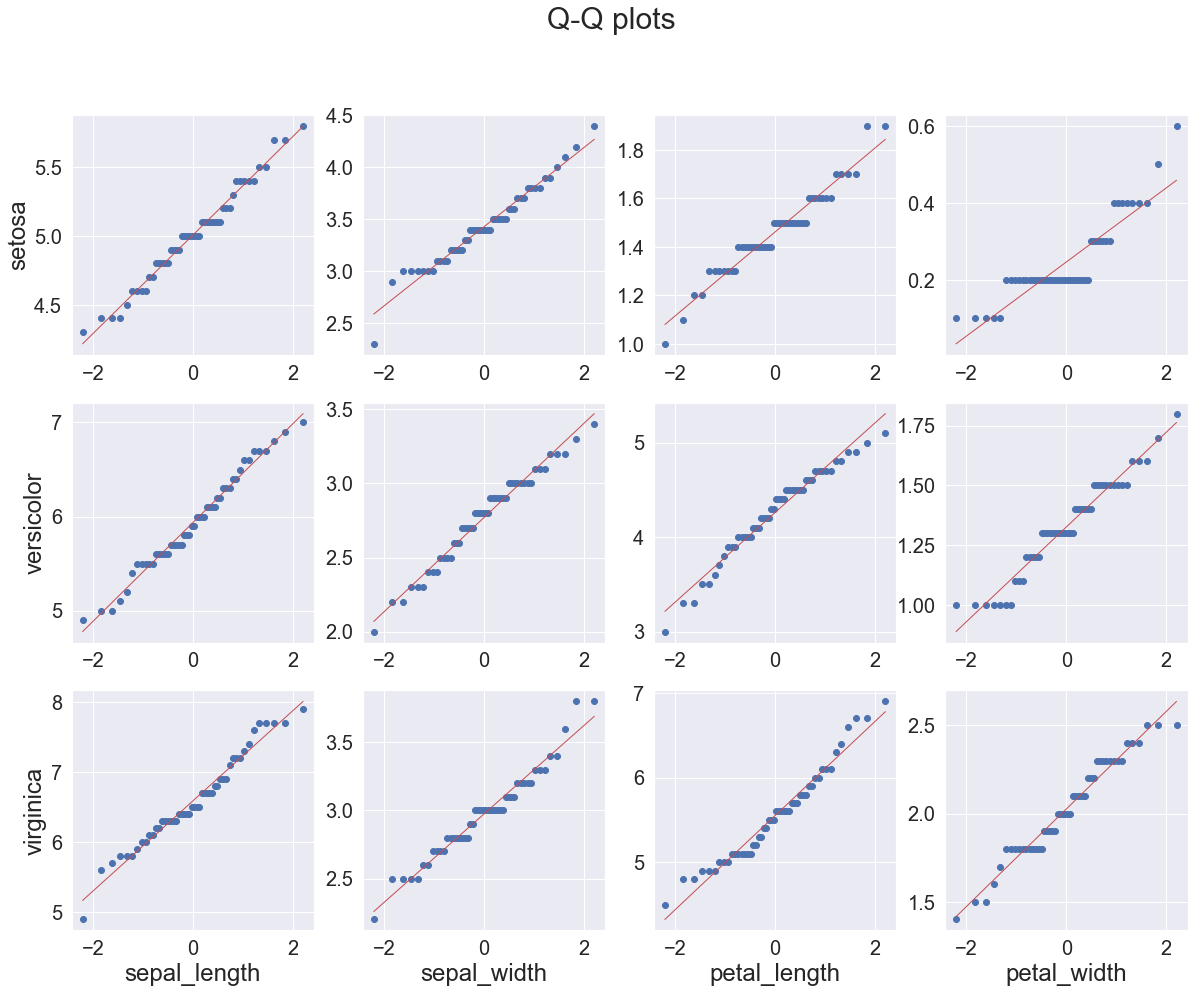

In [5]:
fig = plt.figure(figsize=(20,15))
idx = 1
classes = ['setosa', 'versicolor', 'virginica']
for label in classes:
    for feature in df.columns[:-1]:
        x = df[df['species']==label][feature].values
        plt.subplot(3, 4, idx)
        idx += 1
        qq_points, qq_line = st.probplot(x, plot=plt)
        plt.title("")
        plt.xlabel("")
        plt.ylabel("")
        if (idx - 2) % 4 == 0:
            plt.ylabel(label)
        if idx > 9:
            plt.xlabel(feature)
t = fig.suptitle('Q-Q plots', fontsize=30)
plt.show()

Как видно на Q-Q графике существенные отклонения от нормальности наблюдаются только у признака ширины внутренней доли околоцветника, для построения доверительных интервалов разности средних для всех классов кроме данного используем критерий Стьюдента (Аспина-Уэлша). Для ширины внутренней доли околоцветника построим доверительный интервал с помощью бутстрепа

Размер эффекта будем оценивать с помощью метрики d Когена (Cohen's d) 

In [6]:
def effect_size(x1, x2):
    s = np.sqrt(((len(x1) - 1) * np.std(x1, ddof=1)**2 \
                 + (len(x2) - 1) * np.std(x2, ddof=1)**2) \
                /(len(x1) + len(x2) - 2))
    return np.abs((np.mean(x1) - np.mean(x2))/s)
def effect_size_word(e):
    if (e <= 0.01):
        return "Very small"
    elif (e <= 0.2):
        return "Small"
    elif (e <= 0.5):
        return "Medium"
    elif (e <= 0.8):
        return "Large"
    elif (e <= 1.2):
        return "Huge"
    else:
        return "Very huge"

In [7]:
from itertools import combinations

def mean(x1, x2):
    return np.mean(x1) - np.mean(x2)

for class1, class2 in combinations(classes, 2):
    print(class1, "and", class2)
    print()
    for feature in df.columns[:-1]:
        X1 = df[df['species']==class1][feature].values
        X2 = df[df['species']==class2][feature].values
        if (feature == "petal_width"):
            boot = IndependentSamplesBootstrap(X1, X2)
            conf_int = boot.conf_int(mean, 3000, method='bca', size=1 - 0.05/12).ravel()
        else:
            cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
            conf_int = cm.tconfint_diff(usevar='unequal', alpha=0.05/12)
        eff = effect_size(X1, X2)
        print("Feature", feature, ", confidence interval"
              ": ({:.3f}, {:.3f})".format(conf_int[0], conf_int[1]) ,
              ", effect size: {:.3f} ({})".format(eff, effect_size_word(eff)))
    print()

setosa and versicolor

Feature sepal_length , confidence interval: (-1.190, -0.670) , effect size: 2.104 (Very huge)
Feature sepal_width , confidence interval: (0.454, 0.862) , effect size: 1.891 (Very huge)
Feature petal_length , confidence interval: (-3.009, -2.587) , effect size: 7.899 (Very huge)
Feature petal_width , confidence interval: (-1.172, -0.980) , effect size: 6.816 (Very huge)

setosa and virginica

Feature sepal_length , confidence interval: (-1.886, -1.278) , effect size: 3.077 (Very huge)
Feature sepal_width , confidence interval: (0.247, 0.661) , effect size: 1.290 (Very huge)
Feature petal_length , confidence interval: (-4.334, -3.846) , effect size: 9.997 (Very huge)
Feature petal_width , confidence interval: (-1.899, -1.660) , effect size: 8.557 (Very huge)

versicolor and virginica

Feature sepal_length , confidence interval: (-0.992, -0.312) , effect size: 1.126 (Huge)
Feature sepal_width , confidence interval: (-0.391, -0.017) , effect size: 0.641 (Large)
Featu

Заметим, что здесь мы также сделали поправку Бонферони в связи с множественным посроением доверительных интервалов.

**Вывод**

*Как видно из посчитанных размеров эффектов рассмотренные параметры значительно отличаются для данных классов ирисов, более того так как доверительные интервалы отстоят от нуля различия статистически значимы даже с довольно грубой поправкой Бонферони*